## Import libraries and generate data

In [1]:
"""
Estimating the causal effect of sodium on blood pressure in a simulated example
adapted from Luque-Fernandez et al. (2018):
    https://academic.oup.com/ije/article/48/2/640/5248195
"""

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
import causalml
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import dowhy as dw
from IPython.display import Image, display
from xgboost import XGBRegressor

/home/baold1/yes/envs/dowhy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_data(n=1000, seed=0, beta1=1.05, alpha1=0.4, alpha2=0.3, binary_treatment=True, binary_cutoff=3.5):
    np.random.seed(seed)
    age = np.random.normal(65, 5, n)
    sodium = age / 18 + np.random.normal(size=n)
    if binary_treatment:
        if binary_cutoff is None:
            binary_cutoff = sodium.mean()
        sodium = (sodium > binary_cutoff).astype(int)
    blood_pressure = beta1 * sodium + 2 * age + np.random.normal(size=n)
    proteinuria = alpha1 * sodium + alpha2 * blood_pressure + np.random.normal(size=n)
    hypertension = (blood_pressure >= 140).astype(int)  # not used, but could be used for binary outcomes
    return pd.DataFrame({'blood_pressure': blood_pressure, 'sodium': sodium,
                         'age': age, 'proteinuria': proteinuria})


def estimate_causal_effect(Xt, y, model=LinearRegression(), treatment_idx=0, regression_coef=False):
    model.fit(Xt, y)
    if regression_coef:
        return model.coef_[treatment_idx]
    else:
        Xt1 = pd.DataFrame.copy(Xt)
        Xt1[Xt.columns[treatment_idx]] = 1
        Xt0 = pd.DataFrame.copy(Xt)
        Xt0[Xt.columns[treatment_idx]] = 0
        return (model.predict(Xt1) - model.predict(Xt0)).mean()

In [3]:
n_sample = 100_000
binary_t_df = generate_data(beta1=1.05, alpha1=.4, alpha2=.3, binary_treatment=True, n=n_sample)
continuous_t_df = generate_data(beta1=1.05, alpha1=.4, alpha2=.3, binary_treatment=False, n=n_sample)

## Visualise the data

In [4]:
binary_t_df

,blood_pressure,sodium,age,proteinuria
0,148.730033,1,73.820262,46.624747
1,135.389950,1,67.000786,39.922275
2,139.995197,1,69.893690,43.656931
3,153.409300,1,76.204466,47.880881
4,148.495335,1,74.337790,44.656397
...,...,...,...,...
99995,127.965048,1,63.311426,39.394572
99996,110.372983,0,54.857258,32.721091
99997,138.606597,1,68.630910,43.220365
99998,120.440320,0,59.160847,36.006790


<Axes: xlabel='sodium', ylabel='blood_pressure'>

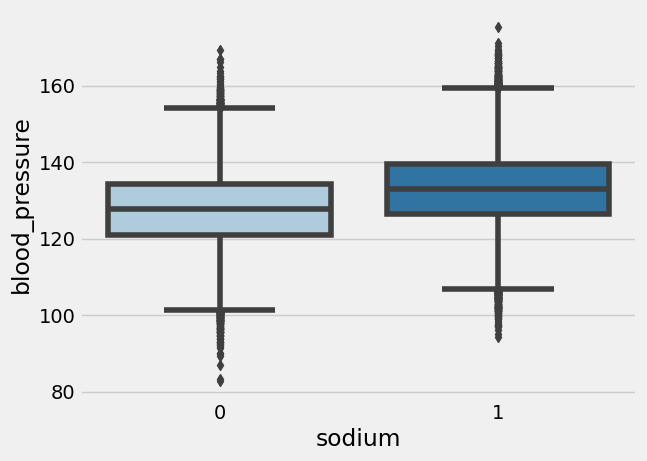

In [5]:
# plot average blood pressure vs sodium
sns.boxplot(x='sodium', y='blood_pressure', data=binary_t_df)

<Axes: xlabel='age_group', ylabel='blood_pressure'>

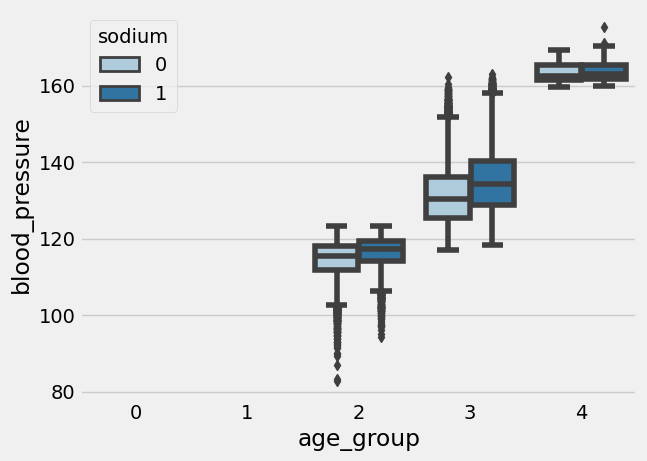

In [6]:
# bin age into age groups: 0-20, 20-40, 40-60, 60-80, 80-100
age_bins = [0, 20, 40, 60, 80, 100]
age_labels = [0, 1, 2, 3, 4]
binary_t_df['age_group'] = pd.cut(binary_t_df['age'], bins=age_bins, labels=age_labels)

# plot average blood pressure vs sodium, stratified by age group
sns.boxplot(x='age_group', y='blood_pressure', hue='sodium', data=binary_t_df)

<Axes: xlabel='proteinuria_group', ylabel='blood_pressure'>

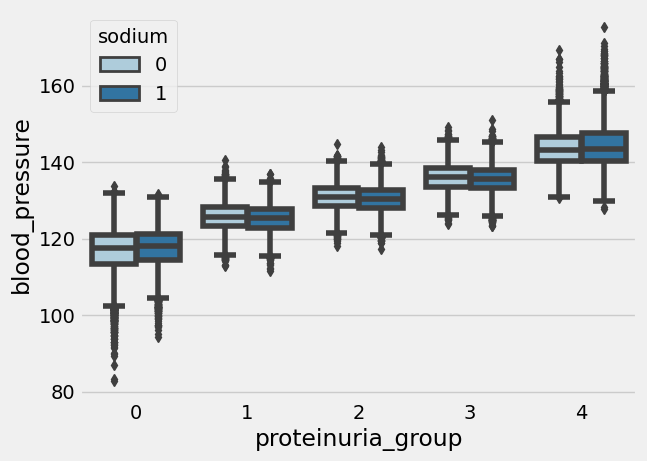

In [7]:
# bin proteinuria into 5 equal-sized groups
binary_t_df['proteinuria_group'] = pd.qcut(binary_t_df['proteinuria'], q=5, labels=False)

# plot average blood pressure vs sodium, stratified by proteinuria group
sns.boxplot(x='proteinuria_group', y='blood_pressure', hue='sodium', data=binary_t_df)

## Estimate effect using sklearn

In [12]:
ate_est_naive = None
ate_est_adjust_all = None
ate_est_adjust_age = None

# for df, name in zip([binary_t_df, continuous_t_df],
#                     ['Binary Treatment Data', 'Continuous Treatment Data']):
for df, name in zip([binary_t_df],
                    ['Binary Treatment Data']):
    print()
    print('### {} ###'.format(name))
    print()

    # Counterfactual estimates
    ate_est_naive = estimate_causal_effect(df[['sodium']], df['blood_pressure'], treatment_idx=0)
    ate_est_adjust_all = estimate_causal_effect(df[['sodium', 'age', 'proteinuria']],
                                                df['blood_pressure'], treatment_idx=0)
    ate_est_adjust_age = estimate_causal_effect(df[['sodium', 'age']], df['blood_pressure'])
    print('# Counterfactual Estimates #')
    print('Naive ATE estimate:\t\t\t\t\t\t\t', ate_est_naive)
    print('ATE estimate adjusting for all covariates:\t', ate_est_adjust_all)
    print('ATE estimate adjusting for age:\t\t\t\t', ate_est_adjust_age)
    print()

    # Linear regression coefficient estimates
    ate_est_naive = estimate_causal_effect(df[['sodium']], df['blood_pressure'], treatment_idx=0,
                                            regression_coef=True)
    ate_est_adjust_all = estimate_causal_effect(df[['sodium', 'age', 'proteinuria']],
                                                df['blood_pressure'], treatment_idx=0,
                                                regression_coef=True)
    ate_est_adjust_age = estimate_causal_effect(df[['sodium', 'age']], df['blood_pressure'],
                                                regression_coef=True)
    print('# Regression Coefficient Estimates #')
    print('Naive ATE estimate:\t\t\t\t\t\t\t', ate_est_naive)
    print('ATE estimate adjusting for all covariates:\t', ate_est_adjust_all)
    print('ATE estimate adjusting for age:\t\t\t\t', ate_est_adjust_age)
    print()



### Binary Treatment Data ###

# Counterfactual Estimates #
Naive ATE estimate:							 5.179692033288887
ATE estimate adjusting for all covariates:	 0.8474239074361092
ATE estimate adjusting for age:				 1.0590826072798332

# Regression Coefficient Estimates #
Naive ATE estimate:							 5.179692033288896
ATE estimate adjusting for all covariates:	 0.8474239074361049
ATE estimate adjusting for age:				 1.0590826072798267



## Solve the problem using CausalML

In [18]:
X = binary_t_df[['age','proteinuria']]
treatment = binary_t_df['sodium']
y = binary_t_df['blood_pressure']

lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.6f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.6f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.6f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl.estimate_ate(X, treatment, y)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.6f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  rl.estimate_ate(X=X, treatment=treatment, y=y)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.6f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): 0.847424 (0.81, 0.89)
Average Treatment Effect (XGBoost): 0.849761 (0.82, 0.88)
Average Treatment Effect (Neural Network (MLP)): 0.537271 (0.50, 0.58)


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

Average Treatment Effect (BaseXRegressor using XGBoost): 0.841245 (0.81, 0.87)


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

Average Treatment Effect (BaseRRegressor using XGBoost): 0.807165 (0.81, 0.81)


## Estimate using Graphical Structural Causal Model and Counterfactual

In [13]:
gml_graph = """graph [directed 1
node [id "Y" label "blood_pressure"]
node [id "T" label "sodium"]
node [id "W" label "age"]
node [id "Z" label "proteinuria"]
edge [source "T" target "Y"]
edge [source "W" target "Y"]
edge [source "W" target "T"]
edge [source "Y" target "Z"]
edge [source "T" target "Z"]
]"""

In [14]:
model = dw.CausalModel(
    data=df,
    graph=gml_graph,
    treatment='sodium',
    outcome='blood_pressure',
)

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                           
─────────(E[blood_pressure|age])
d[sodium]                       
Estimand assumption 1, Unconfoundedness: If U→{sodium} and U→blood_pressure then P(blood_pressure|sodium,age,U) = P(blood_pressure|sodium,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



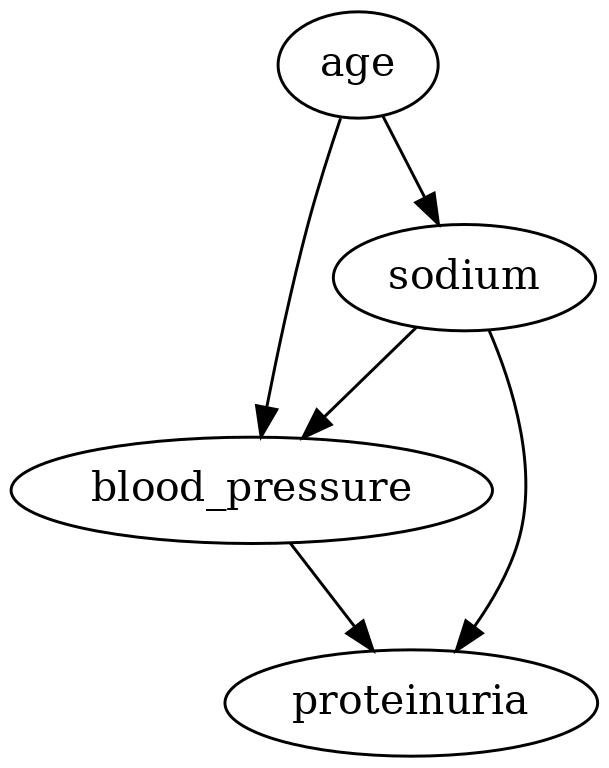

In [15]:
model.view_model()
display(Image(filename="causal_model.png"))

In [16]:
methods = ['backdoor.propensity_score_stratification', 
            'backdoor.propensity_score_matching',
            'backdoor.propensity_score_weighting',
            'backdoor.linear_regression'
            ]

In [17]:
for method in methods:
    try:
        print(f'use method: {method}')
        estimate = model.estimate_effect(identified_estimand,
                                        method_name=method,
                                        test_significance=True)
        print(f'Estimate for {method}: {estimate.value}')
    except Exception as e:
        print(f'Error for {method}: {e}')

use method: backdoor.propensity_score_stratification
Estimate for backdoor.propensity_score_stratification: 1.070021537787718
use method: backdoor.propensity_score_matching
Estimate for backdoor.propensity_score_matching: 1.0595227232730122
use method: backdoor.propensity_score_weighting
Estimate for backdoor.propensity_score_weighting: 1.0547911684616622
use method: backdoor.linear_regression
Estimate for backdoor.linear_regression: 1.0590826072799189
